Imports that will be needed later on

In [112]:
import sys
sys.path.append("..")
sys.path.append("../modeling")

import home_ranges as hr

from keplergl import KeplerGl

import pandas as pd
import numpy as np
#import warnings
#import mlflow
import matplotlib.pyplot as plt
#import rasterio
import geopandas as geopd
#import rasterio.rio
import seaborn as sns
import datetime as dt 

from rasterio.plot import show

from datetime import datetime, timedelta
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely

import geopandas as gpd

In [38]:
foxes_all = geopd.read_file("../data/cleaned_shapefiles/foxes_all.shp")
#foxes_resamp = geopd.read_file("../data/cleaned_shapefiles/foxes_resamp.shp")
sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")
dens_all = geopd.read_file("../data/cleaned_shapefiles/dens_norrbotten.shp")

In [39]:
!pip freeze | egrep pyp

pyparsing==3.0.9
pyproj==3.4.1


In [40]:
''' 
Function to get an array of diffs in seconds between time stamps of subsequent rows of a DataFrame.

Input:
df: DataFrame containing column of time stamps
df_time_col: name of column with time stamps
id: identifier for which time steps are calculated

Returns:
Array of float, representing seconds passed since preceding entry in DataFrame.
NaN if there is no preceeding row for the same id
'''

def get_time_diffs(df, df_time_col = "t_", id = "id"):
    fmt = '%Y-%m-%d-%H:%M:%S'
    time_diff = []
    for i, _ in enumerate(df.t_):
        if i > 0 and df.iloc[i-1][id] == df.iloc[i][id] :
            time_1 = datetime.strptime(df.iloc[i-1][df_time_col], fmt)
            time_2 = datetime.strptime(df.iloc[i][df_time_col], fmt)
            time_diff.append((time_2 - time_1).total_seconds())
        else:
            time_diff.append(np.nan)
    return time_diff



''' 
Function to get an array of distance in seconds between coords of subsequent rows of a DataFrame.

Input:
df: DataFrame containing column of coords
df_time_col: name of column with coords
id: identifier for which coords are calculated

Returns:
Array of float, representing seconds passed since preceding entry in DataFrame.
NaN if there is no preceeding row for the same id
'''

def get_distance(df, x = "x_", y= "y_", id = "id"): 
  travel_distance = []
  for i, _ in enumerate(df.t_):
    if i > 0 and df[id].iloc[i-1] == df[id].iloc[i]:
      x_diff = df[x].iloc[i-1] - df[x].iloc[i]
      y_diff = df[y].iloc[i-1] - df[y].iloc[i]
      tot_diff = np.sqrt(np.square(x_diff) + np.square(y_diff) )
      travel_distance.append(int(tot_diff))
    else:
      travel_distance.append(np.nan)
  return travel_distance



In [41]:
''' 
Function to convert a shapely Polygon object into a GeoJson.
As GeoJson requires CRS4326, input will be transformed unless it also is in this format

Input:
poly: shapely Polygon object
in_crs: crs system of coords in poly

Returns:
GeoJson object representing poly
'''

def polygon_to_geojson(poly, in_crs = 3006):
    poly_coords = poly.boundary.coords.xy    
    s= pd.DataFrame( [Point(x,y) for x,y in zip( poly_coords[0], poly_coords[1])])
    s.columns = ["geometry"]
    gdf = gpd.GeoDataFrame(s, crs=in_crs)
    if in_crs != 4326:
        gdf = gdf.to_crs(epsg= 4326)
    geojson = {'type':'Polygon', 'coordinates':[]}
    f  = []
    for point in gdf.geometry:
        f.append([point.x, point.y])
    geojson['coordinates'].append(f)
    return geojson

#def dataframe_convert_coords(df, coord_in = 3006, coord_out = 4326):
 #   gdf = gpd.GeoDataFrame(df, crs=coord_in)
  #  return gdf.to_crs(epsg= coord_out)


''' 
Function to calculate the distance between a point, and the farthest point of a shapely Polygon

Input:
point: shapely Point object
point: shapely Polygon object

Returns:
distance between point and farthest point of poly
'''
def max_dist_point_poly(point, poly):
    max_dist = 0
    poly_coords = poly.boundary.coords.xy
    for point_poly in [Point(x,y) for x,y in zip( poly_coords[0], poly_coords[1])]:
        if point.distance(point_poly) > max_dist:
            max_dist = point.distance(point_poly)
    return max_dist


''' 
Function to turn a DataFrame with columns for coords and an timestamp into a GeoJson object
representing a trip in Kepler Gl

Input:
df: DataFrame
properties: List of properties to be associated with each trip
lat: name of the column with latitude coords
lon: name of the column with longitude coords
elev: name of the column with elevation above sea level
time: name of the column with time stamp
id: name of the column with id by which to group together for a trip

Returns:
distance between point and farthest point of poly
'''
def df_to_geojson_trip(df, properties, lat='geo_kepler_lat', lon='geo_kepler_lon', elev = 'elev', time = 'timestamp', id = 'id'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for fox_id in df[id].unique():
        i =0
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'LineString',
                               'coordinates':[]}}
        for _, row in df.query('id == @fox_id').iterrows():        
       #     feature['geometry']['coordinates'].append([row[lon], row[lat], row[elev],  int(row[time])])
            feature['geometry']['coordinates'].append([row[lon], row[lat], row[elev], 1564184363 + 10 * i])# row[time]])
            i += 1
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson


In [42]:
foxes_all["travel_distance"] = get_distance(foxes_all)
foxes_all["time_diff"] = get_time_diffs(foxes_all)

foxes_all["fox_day"] = [str(datetime.strptime(x, '%Y-%m-%d-%H:%M:%S' ) + timedelta(hours=12))[:10]  for x in foxes_all.t_ ]
foxes_all["month"] = [x[5:7] for x in foxes_all.fox_day]
foxes_all["year"] = [x[:4] for x in foxes_all.fox_day]

factor = 100
foxes_all["geo_round"] = [(int(x/factor) * factor + factor / 2, int(y/factor)  * factor + factor / 2) for x, y in zip(foxes_all.x_, foxes_all.y_) ]


In [43]:
test = foxes_all.geometry
gdf = gpd.GeoDataFrame(test, crs=3006)


gdf = gdf.to_crs(epsg= 4326)

foxes_all["geo_kepler_lat"] = [geo.y for geo in gdf.geometry]
foxes_all["geo_kepler_lon"] = [geo.x for geo in gdf.geometry]

foxes_all

points_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).count().rename(columns={"time_diff": "points_this_day"})

max_window_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).max().rename(columns={"time_diff": "max_window"})

a = pd.merge( foxes_all,points_per_day, left_on=["id", "fox_day"], right_on=["id", "fox_day"] )
b = pd.merge( max_window_per_day, a , left_on=["id", "fox_day"], right_on=["id", "fox_day"] )
#b[["id", "fox_day", "t_", "time_diff", "points_this_day", "max_window"]]




In [44]:

for fox_id in foxes_all.id.unique():
    fox_hr_poly = hr.hr_area(foxes_all.query('id ==@fox_id'))


In [45]:
#x = pd.DataFrame(columns=["a", "b", "c"])

y = foxes_all.groupby(["id", "sex"], as_index=False).count()[["id","sex"]]

#for z in y.id:
 #   print(z)
#y["geometry"] = [polygon_to_geojson(hr.hr_area(foxes_all.query('id ==@x'))) for x in y.id ]
y["hr_area"] = [hr.hr_area(foxes_all.query('id ==@x')).area for x in y.id ]
#y.describe()


In [46]:
y.hr_area.min() / y.hr_area.max()

0.12282918902015916

In [47]:

circle_all = Polygon()
hr_all = Polygon()
intersect_all = Polygon()
map1=KeplerGl(height=500)

cols_df = ["id", "geo_kepler_lat", "geo_kepler_lon"]
cols_geo = ['fox_day']


for fox_id in foxes_all.query("id == '2019-FSBD609-002'").id.unique():    
    fox_hr_poly = hr.hr_area(foxes_all.query('id ==@fox_id'))
  #  den = foxes_all.query('id ==@fox_id')[["id", "geo_round", "t_"]].groupby(["id", "geo_round"], as_index=False).count().sort_values(by="t_").tail(1).geo_round 
    #den_coord = Point(tuple(den)[0][0] , tuple(den)[0][1] )
    #circle = den_coord.buffer(max_dist_point_poly(den_coord, fox_hr_poly))
  #  x = hr_all.intersection(fox_hr_poly)
   # intersect_all = intersect_all.union(x)
   # circle_all = circle_all.union(circle)
    #hr_all = hr_all.union(fox_hr_poly)
    geojson = df_to_geojson_trip(foxes_all.query('id ==@fox_id'), cols_geo)
    map1.add_data(data= foxes_all.query("id == @fox_id ")[cols_df], name = "where did the fox go")
    map1.add_data(data=geojson,name='Where does fox  ' + fox_id + ' trot?')

  
    
    #map1.add_data(data=g(den_coord, columns="geometry"), name = "center" + fox_id)
    map1.add_data(data = polygon_to_geojson(fox_hr_poly), name='homerange' + fox_id)
    #map1.add_data(data = polygon_to_geojson(circle), name="circle" + fox_id)


map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'where did the fox go': {'index': [23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 2342…

In [48]:
sample_points_by_hr_with_id = pd.DataFrame(columns=["geometry", "id"])

for fox_id in foxes_all.id.unique():
    points = sample_points.intersection(hr.hr_area(foxes_all.query('id ==@fox_id')))
    df_temp = pd.DataFrame(columns=["geometry"], data=points[~points.is_empty].to_list())
    df_temp["id"] = fox_id
    sample_points_by_hr_with_id = pd.concat([sample_points_by_hr_with_id, df_temp ])

sample_points_in_hr_with_id = sample_points_by_hr_with_id.drop_duplicates().merge(sample_points, on = "geometry")

a = sample_points_in_hr_with_id[["id", "soil", "veg"]].groupby(["id", "veg"], as_index=False).count()
b = sample_points_in_hr_with_id[["id", "soil", "veg"]].groupby(["id", "soil"], as_index=False).count()

[]

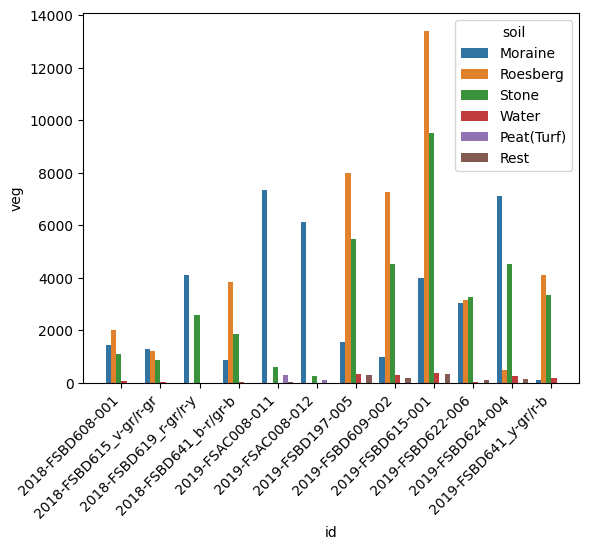

In [49]:
chart_soil = sns.barplot(data = b[["id", "soil", "veg"]], x="id", y="veg", hue="soil")
chart_soil.set_xticklabels(chart_soil.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_soil.plot()

[]

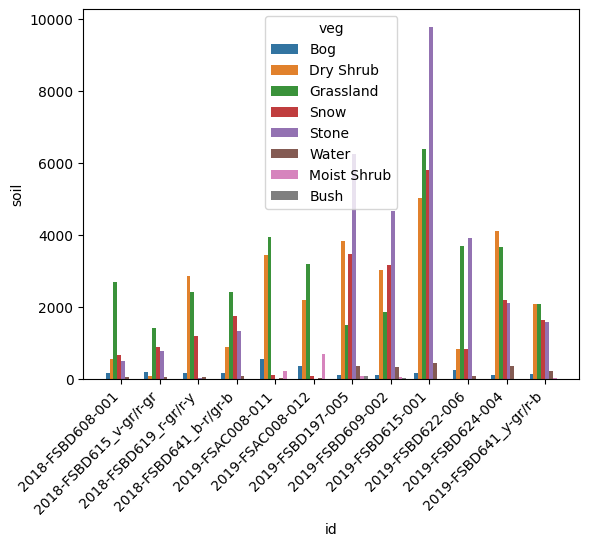

In [50]:
chart_veg = sns.barplot(data = a[["id", "soil", "veg"]], x="id", y="soil", hue="veg")
chart_veg.set_xticklabels(chart_veg.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_veg.plot()

In [55]:
points_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).count().rename(columns={"time_diff": "points_this_day"})

max_window_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).max().rename(columns={"time_diff": "max_window"})

a = pd.merge( foxes_all,points_per_day, left_on=["id", "fox_day"], right_on=["id", "fox_day"] )
b = pd.merge( a, max_window_per_day,  left_on=["id", "fox_day"], right_on=["id", "fox_day"] )

foxes_relevant_days = b.query("max_window < 1000 and points_this_day > 80")

#for rel_day in foxes_relevant_days:



In [61]:
foxes_relevant_days = b.query("max_window < 2000 and points_this_day > 40") #.groupby(["id", "fox_day"]).count()

In [69]:
foxes_relevant_days[["id", "fox_day","travel_distance"] ].groupby(["id", "fox_day"]).sum()

travel_distance
id                     fox_day                    
2018-FSBD615_v-gr/r-gr 2018-09-08     18968.551673
                       2018-09-09     18341.469561
                       2018-09-10     21483.303563
                       2018-09-12     43305.943513
                       2018-09-29     23374.501149
...                                            ...
2019-FSBD641_y-gr/r-b  2019-09-09     28798.911090
                       2019-09-10     27723.904844
                       2019-09-13     31685.354073
                       2019-09-14     35116.561285
                       2019-09-15     32094.428075

[104 rows x 1 columns]

In [121]:

foxes_poly_day = gpd.GeoDataFrame(
    foxes_relevant_days[["id", "fox_day", "x_", "y_"]].groupby(["id", "fox_day"], as_index=False).apply(
        lambda d: pd.Series(
            {
   #             "name": "|".join(d["name"].tolist()),
                "geometry": shapely.geometry.Polygon(
                    d.loc[:, ["x_", "y_"]].values
                ),
            }
        )
    )
)
foxes_poly_day.eval( "trip_area = geometry.area / 1000000", inplace=True )

In [122]:
b = foxes_poly_day.geometry[5]
a = MultiPolygon(b)
#MultiPolygon(foxes_poly_day.geometry[2]).union(MultiPolygon(foxes_poly_day.geometry[1]))

TypeError: 'Polygon' object is not iterable

In [ ]:
c = foxes_relevant_days[["id", "fox_day", "month","travel_distance"]].groupby(["id", "fox_day", "month"], as_index=False).sum()

d = c[[ "month", "travel_distance"]].groupby([ "month"]).agg([np.min, np.max, np.mean, np.median, np.count_nonzero ], as_index=False)
d
#foxes_all.query("month == '01'")
#c.query("id == '2019-FSBD609-002' and month == '08'")
foxes_all.query("month == '09'").fox_day.value_counts().sort_index()
foxes_all.query("month == '09'")[["id","year"]].groupby(["id", "year"]).count()

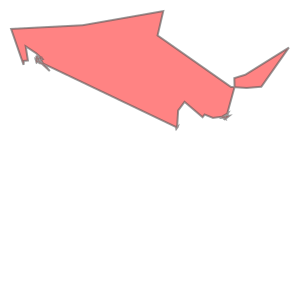

In [127]:
foxes_poly_day.geometry[65]

In [151]:
fox_id = '2018-FSBD619_r-gr/r-y'

map2 = KeplerGl(height=500)
#map2.add_data(polygon_to_geojson( hr.hr_area(foxes_all.query('id ==@fox_id')) ), name = "hr")
map2.add_data(data = dens_all, name = "dens")
i = 0
for x in foxes_poly_day.query("id ==@fox_id")[:3].geometry:
    map2.add_data(polygon_to_geojson(x), name = "hr_" + str(i))
    i+=1
    

map2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'dens': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [140]:
foxes_poly_day.id.value_counts()

2019-FSBD641_y-gr/r-b     43
2018-FSBD641_b-r/gr-b     22
2019-FSBD609-002          18
2018-FSBD619_r-gr/r-y     10
2018-FSBD615_v-gr/r-gr     5
2019-FSBD624-004           3
2019-FSBD197-005           2
2019-FSAC008-012           1
Name: id, dtype: int64